# start

- http://localhost:8081/notebooks/git/recsys20/working/0324_6_3_lgb_feat_engr-1e7.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/mdl0404_1__xgb_mean_encode.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/eda_0404_1.ipynb#v.s.-target
- https://www.kaggle.com/discdiver/category-encoders-examples
- https://www.kaggle.com/snakayama/lightgbm-using-optuna-optuna-lightgbm

In [1]:
TGT='Like'
PRFX='Like0411_1'

trntmstmp=1584412344
tsttmstmp=1586133347

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

SEED=101

valsz = int(5e5)#int(1e5)
trnsz = int(5e5)#int(5e5)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-06 00:35:47']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
# import lightgbm as lgb
import category_encoders as ce
import gc

import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
# optuna.logging.set_verbosity(optuna.logging.ERROR)
import optuna.integration.lightgbm as lgb
optuna.logging.disable_default_handler()


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL like
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [4]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

(500000, 24)


retwt          0.112638
reply          0.027980
like           0.439010
retwt_cmmnt    0.007676
dtype: float64

CPU times: user 3.82 s, sys: 392 ms, total: 4.22 s
Wall time: 4.21 s


## maybe oversample

In [5]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [6]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

(500000, 24)


retwt          0.113632
reply          0.027396
like           0.438598
retwt_cmmnt    0.007824
dtype: float64

CPU times: user 4.7 s, sys: 352 ms, total: 5.05 s
Wall time: 5.04 s


In [7]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

(500000, 24) 0.438598
500000 219299 500000 219299


,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u1_create_tm,u2id,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,retwt,reply,like,retwt_cmmnt
0,101\t56898\t137\t14248\t10567\t77966\t11166\t1...,NaN,A964AF200DAFFEBCB632CE2196DFBE6F,NaN,NaN,NaN,Retweet,022EC308651FACB02794A8147AEE1B78,1581227402,E43C242721C2336F88D163ADFDB2A364,27901,306,False,1351736247,06E9B34C49824F5C612B01F3DF66C4B8,48,977,False,1493475569,False,True,False,False,False
1,101\t29922\t10230\t112\t11368\t112\t12469\t169...,NaN,CA95806CCD16ADD6164D8B632345A5B6,NaN,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581415813,520F4141FB74447AA2D5100C12656DF2,190829,2227,True,1246308293,06E9B485CA5F2757CB554B0244FE2FA4,2024,1227,False,1234745553,False,False,False,True,False
2,101\t16358\t10107\t117\t146\t100\t181\t32342\t...,NaN,EAB281F4E0B985324DB134D922D7753C,NaN,NaN,NaN,Quote,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581524517,EC1254C86CED1D8F2B556786329FD939,225223,1365,True,1238211373,06E9B485CA5F2757CB554B0244FE2FA4,2024,1227,False,1234745553,False,True,False,True,False
3,101\t49004\t24951\t11517\t21793\t49004\t46900\...,E35EBE28C67E02E3EAABD4D383303A10\tBF43374FADDC...,55F436653590B79DC49DCA2FC5E6BA6E,Photo,NaN,NaN,TopLevel,06D61DCBBE938971E1EA0C38BD9B5446,1581098413,09567D1DEB473ABA2CD04D06F1F6D22D,3110429,39,True,1243169868,06E9B6ABEB6C57CA5A394DADF375D940,557,466,False,1509320658,False,False,False,True,False
4,101\t320\t108660\t18492\t105861\t26349\t10174\...,NaN,2F374BA8A03CFA7B51594FBBD45E4BA6,Photo,E07397470C5AD4AC2420A832A49E045B,476213C6321CD12B64C1FB76A6CE02CA,TopLevel,4DC22C3F31C5C43721E6B5815A595ED6,1581158393,DF856F242E9519638FD447D0CCFA06DF,4245504,54,True,1248789982,06E9B7217C92B280231E835F1B686176,8,74,False,1346060212,False,False,False,False,False


Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u2_create_tm', 'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

## prep and features

In [8]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    set_u1 = set(df.u1id)
    set_u2 = set(df.u2id)
    df['u1inu2']=df.u1id.isin(set_u2)
    df['u2inu1']=df.u2id.isin(set_u1)

    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    

    #freq of feature values
    print(dtnow(), 'freq of columns using CountEncoder')
    encoder = ce.CountEncoder()
    encoded = encoder.fit_transform(
    df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
       'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
    encoded = encoded.astype(int)/lendf
    encoded.columns = [f'frq_{col}' for col in encoded.columns]
    df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
    print(dtnow(), 'freq of tags')
    for tgnm in tgnms:
        vs = [j for i in df[f'lst_{tgnm}'] for j in i]
        cnt = Counter(vs)
        frq = {k:v/lendf for k,v in cnt.items()}
        df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
        df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
    df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)

    print(dtnow(), 'done')
    return df

In [9]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

2020-04-11 21:42:53 start
2020-04-11 21:43:01 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-11 21:43:16 freq of tags
2020-04-11 21:43:20 done
CPU times: user 23.1 s, sys: 3.5 s, total: 26.6 s
Wall time: 26.4 s


In [10]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

2020-04-11 21:43:20 start
2020-04-11 21:43:28 freq of columns using CountEncoder
2020-04-11 21:43:39 freq of tags
2020-04-11 21:43:43 done
CPU times: user 21.2 s, sys: 2.25 s, total: 23.4 s
Wall time: 23.3 s


## tr vl split and target encoding

In [11]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

30

In [12]:
dftr.columns

Index(['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt',
       'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt', 'u1inu2',
       'u2inu1', 'len_toks', 'n_media_Photo', 'n_media_Video', 'n_media_GIF',
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media', 'has_domns',
       'n_domns', 'dayofweek', 'hour', 'tmdlta_u2u1', 'tmdlta_twtu1',
       'tmdlta_twtu2', 'twt_age', 'u1_age', 'u2_age', 'u1_fllwer_cnt_by_age',
       'u1_fllwng_cnt_by_age', 'u1u2', 'langhour', 'frq_twtid', 'frq_twttyp',
       'frq_lang', 'frq_u1id', 'frq_u1_fllwing_cnt', 'frq_u1_vrfed',
       'frq_u2id', 'frq_u2_fllwer_cnt', 'frq_u2_vrfed', 'frq_u1_fllw_u2',
       'frq_n_media_Photo', 'frq_n_media_Video', 'frq_n_media_GIF',
       'frq_has_hshtgs', 'frq_n_hshtgs', 'frq_has_media', 'frq_n_media',
       'frq_has_domns', 'frq_n_domns', 'frq_dayofweek', 'frq_hour', 'frq_u1u2',
       'frq_langhour', 'sumfrq_hshtgs', 

In [13]:
%%time
col2tgtenc=['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
   'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
   'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
   'dayofweek', 'hour', 'u1u2', 'langhour']
tgt_encoder = ce.TargetEncoder()
encoded_tr = tgt_encoder.fit_transform(dftr[col2tgtenc].astype(object), dftr[TCOL])
encoded_vl = tgt_encoder.transform(dfvl[col2tgtenc].astype(object))
encoded_val = tgt_encoder.transform(dfval[col2tgtenc].astype(object))

tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tr.columns]
encoded_tr.columns = tgtenc_columns
encoded_vl.columns = tgtenc_columns
encoded_val.columns = tgtenc_columns

dftr = pd.concat([dftr, encoded_tr], 1)
dfvl = pd.concat([dfvl, encoded_vl], 1)
dfval = pd.concat([dfval, encoded_val], 1)


CPU times: user 22.1 s, sys: 5.58 s, total: 27.7 s
Wall time: 27.6 s


In [14]:
cols_category=['twttyp', 'lang', 'langhour']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

In [15]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

# model

## cols_feat

In [16]:
print(len(cols_feat))
cols_feat=['twttyp',
 'lang',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'u1inu2',
 'u2inu1',
 'len_toks',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
#  'has_hshtgs',
 'n_hshtgs',
#  'has_media',
 'n_media',
#  'has_domns',
 'n_domns',
 'dayofweek',
 'hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_age',
 'u2_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'langhour',
#  'frq_twtid',
#  'frq_twttyp',
#  'frq_lang',
#  'frq_u1id',
#  'frq_u1_fllwing_cnt',
#  'frq_u1_vrfed',
#  'frq_u2id',
#  'frq_u2_fllwer_cnt',
#  'frq_u2_vrfed',
#  'frq_u1_fllw_u2',
#  'frq_n_media_Photo',
#  'frq_n_media_Video',
#  'frq_n_media_GIF',
#  'frq_has_hshtgs',
#  'frq_n_hshtgs',
#  'frq_has_media',
#  'frq_n_media',
#  'frq_has_domns',
#  'frq_n_domns',
#  'frq_dayofweek',
#  'frq_hour',
#  'frq_u1u2',
#  'frq_langhour',
#  'sumfrq_hshtgs',
#  'maxfrq_hshtgs',
#  'sumfrq_media',
#  'maxfrq_media',
#  'sumfrq_links',
#  'maxfrq_links',
#  'sumfrq_domns',
#  'maxfrq_domns',
#  'tgtenc_twtid',
#  'tgtenc_twttyp',
#  'tgtenc_lang',
#  'tgtenc_u1id',
#  'tgtenc_u1_fllwing_cnt',
#  'tgtenc_u1_vrfed',
#  'tgtenc_u2id',
#  'tgtenc_u2_fllwer_cnt',
#  'tgtenc_u2_vrfed',
#  'tgtenc_u1_fllw_u2',
#  'tgtenc_n_media_Photo',
#  'tgtenc_n_media_Video',
#  'tgtenc_n_media_GIF',
#  'tgtenc_has_hshtgs',
#  'tgtenc_n_hshtgs',
#  'tgtenc_has_media',
#  'tgtenc_n_media',
#  'tgtenc_has_domns',
#  'tgtenc_n_domns',
#  'tgtenc_dayofweek',
#  'tgtenc_hour',
#  'tgtenc_u1u2',
#  'tgtenc_langhour'
          ]
print(len(cols_feat))

86
29


In [17]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat
results['tgt_encoder'] = tgt_encoder
results['col2tgtenc'] = col2tgtenc

In [18]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,    
}
results['params'] = params

In [19]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
best_params, tuning_history = {}, []
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                best_params=best_params,
                tuning_history=tuning_history,
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres
results['best_params']=best_params
results['tuning_history']=tuning_history

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.588327	vl's binary_logloss: 0.600815
[200]	tr's binary_logloss: 0.578572	vl's binary_logloss: 0.597927
[300]	tr's binary_logloss: 0.571695	vl's binary_logloss: 0.596792
[400]	tr's binary_logloss: 0.565597	vl's binary_logloss: 0.595998
[500]	tr's binary_logloss: 0.560364	vl's binary_logloss: 0.595957
[600]	tr's binary_logloss: 0.555002	vl's binary_logloss: 0.595371
[700]	tr's binary_logloss: 0.55013	vl's binary_logloss: 0.595128
[800]	tr's binary_logloss: 0.545763	vl's binary_logloss: 0.594969
Early stopping, best iteration is:
[758]	tr's binary_logloss: 0.547682	vl's binary_logloss: 0.594858


tune_feature_fraction, val_score: 0.594858:  14%|#4        | 1/7 [00:26<02:38, 26.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.587026	vl's binary_logloss: 0.60081
[200]	tr's binary_logloss: 0.577435	vl's binary_logloss: 0.59813
[300]	tr's binary_logloss: 0.570598	vl's binary_logloss: 0.597018
[400]	tr's binary_logloss: 0.56434	vl's binary_logloss: 0.596392
[500]	tr's binary_logloss: 0.55849	vl's binary_logloss: 0.596196
[600]	tr's binary_logloss: 0.553121	vl's binary_logloss: 0.596003
[700]	tr's binary_logloss: 0.548094	vl's binary_logloss: 0.595711
[800]	tr's binary_logloss: 0.543201	vl's binary_logloss: 0.595416
Early stopping, best iteration is:
[784]	tr's binary_logloss: 0.544	vl's binary_logloss: 0.595309


tune_feature_fraction, val_score: 0.594858:  29%|##8       | 2/7 [00:51<02:10, 26.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.586594	vl's binary_logloss: 0.600925
[200]	tr's binary_logloss: 0.576402	vl's binary_logloss: 0.598432
[300]	tr's binary_logloss: 0.569372	vl's binary_logloss: 0.597609
[400]	tr's binary_logloss: 0.562492	vl's binary_logloss: 0.596779
[500]	tr's binary_logloss: 0.556246	vl's binary_logloss: 0.596522
[600]	tr's binary_logloss: 0.550785	vl's binary_logloss: 0.596392
[700]	tr's binary_logloss: 0.54586	vl's binary_logloss: 0.596185
[800]	tr's binary_logloss: 0.540926	vl's binary_logloss: 0.59611
Early stopping, best iteration is:
[777]	tr's binary_logloss: 0.541933	vl's binary_logloss: 0.596018


tune_feature_fraction, val_score: 0.594858:  43%|####2     | 3/7 [01:17<01:43, 25.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.58543	vl's binary_logloss: 0.601364
[200]	tr's binary_logloss: 0.574304	vl's binary_logloss: 0.598618
[300]	tr's binary_logloss: 0.566854	vl's binary_logloss: 0.597877
[400]	tr's binary_logloss: 0.560301	vl's binary_logloss: 0.597366
[500]	tr's binary_logloss: 0.55417	vl's binary_logloss: 0.59745
Early stopping, best iteration is:
[416]	tr's binary_logloss: 0.559275	vl's binary_logloss: 0.59725


tune_feature_fraction, val_score: 0.594858:  57%|#####7    | 4/7 [01:34<01:09, 23.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.583937	vl's binary_logloss: 0.60138
[200]	tr's binary_logloss: 0.572059	vl's binary_logloss: 0.599164
[300]	tr's binary_logloss: 0.564628	vl's binary_logloss: 0.598524
[400]	tr's binary_logloss: 0.55686	vl's binary_logloss: 0.597806
[500]	tr's binary_logloss: 0.550344	vl's binary_logloss: 0.597853
Early stopping, best iteration is:
[409]	tr's binary_logloss: 0.556202	vl's binary_logloss: 0.59769


tune_feature_fraction, val_score: 0.594858:  71%|#######1  | 5/7 [01:50<00:42, 21.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.58375	vl's binary_logloss: 0.601637
[200]	tr's binary_logloss: 0.571174	vl's binary_logloss: 0.599574
[300]	tr's binary_logloss: 0.562565	vl's binary_logloss: 0.599174
[400]	tr's binary_logloss: 0.555104	vl's binary_logloss: 0.598872
[500]	tr's binary_logloss: 0.547976	vl's binary_logloss: 0.598977
Early stopping, best iteration is:
[450]	tr's binary_logloss: 0.551248	vl's binary_logloss: 0.59879


tune_feature_fraction, val_score: 0.594858:  86%|########5 | 6/7 [02:09<00:20, 20.52s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.583129	vl's binary_logloss: 0.602088
[200]	tr's binary_logloss: 0.570682	vl's binary_logloss: 0.600458
[300]	tr's binary_logloss: 0.56171	vl's binary_logloss: 0.599962
[400]	tr's binary_logloss: 0.553808	vl's binary_logloss: 0.599785
[500]	tr's binary_logloss: 0.54683	vl's binary_logloss: 0.599822
Early stopping, best iteration is:
[410]	tr's binary_logloss: 0.553037	vl's binary_logloss: 0.59964


tune_num_leaves, val_score: 0.594858:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.561538	vl's binary_logloss: 0.595902
[200]	tr's binary_logloss: 0.540786	vl's binary_logloss: 0.594039
[300]	tr's binary_logloss: 0.524364	vl's binary_logloss: 0.594214
Early stopping, best iteration is:
[204]	tr's binary_logloss: 0.540061	vl's binary_logloss: 0.594024


tune_num_leaves, val_score: 0.594024:   5%|5         | 1/20 [00:14<04:33, 14.38s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.578871	vl's binary_logloss: 0.598698
[200]	tr's binary_logloss: 0.565935	vl's binary_logloss: 0.596291
[300]	tr's binary_logloss: 0.556701	vl's binary_logloss: 0.595676
[400]	tr's binary_logloss: 0.547818	vl's binary_logloss: 0.595259
Early stopping, best iteration is:
[367]	tr's binary_logloss: 0.550584	vl's binary_logloss: 0.595171


tune_num_leaves, val_score: 0.594024:  10%|#         | 2/20 [00:30<04:28, 14.92s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.576042	vl's binary_logloss: 0.597907
[200]	tr's binary_logloss: 0.562073	vl's binary_logloss: 0.595488
[300]	tr's binary_logloss: 0.551319	vl's binary_logloss: 0.595205
[400]	tr's binary_logloss: 0.541693	vl's binary_logloss: 0.594704
Early stopping, best iteration is:
[396]	tr's binary_logloss: 0.542116	vl's binary_logloss: 0.594681


tune_num_leaves, val_score: 0.594024:  15%|#5        | 3/20 [00:51<04:43, 16.67s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.583276	vl's binary_logloss: 0.599092
[200]	tr's binary_logloss: 0.571867	vl's binary_logloss: 0.596536
[300]	tr's binary_logloss: 0.563737	vl's binary_logloss: 0.595891
[400]	tr's binary_logloss: 0.556833	vl's binary_logloss: 0.595546
[500]	tr's binary_logloss: 0.54955	vl's binary_logloss: 0.59535
[600]	tr's binary_logloss: 0.543285	vl's binary_logloss: 0.595138
[700]	tr's binary_logloss: 0.537034	vl's binary_logloss: 0.595138
[800]	tr's binary_logloss: 0.531605	vl's binary_logloss: 0.595159
Early stopping, best iteration is:
[731]	tr's binary_logloss: 0.535415	vl's binary_logloss: 0.594994


tune_num_leaves, val_score: 0.594024:  20%|##        | 4/20 [01:30<06:14, 23.44s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.589739	vl's binary_logloss: 0.601247
[200]	tr's binary_logloss: 0.579886	vl's binary_logloss: 0.598119
[300]	tr's binary_logloss: 0.573644	vl's binary_logloss: 0.597195
[400]	tr's binary_logloss: 0.568258	vl's binary_logloss: 0.596587
[500]	tr's binary_logloss: 0.562566	vl's binary_logloss: 0.596089
[600]	tr's binary_logloss: 0.558018	vl's binary_logloss: 0.595969
[700]	tr's binary_logloss: 0.553599	vl's binary_logloss: 0.595865
[800]	tr's binary_logloss: 0.549101	vl's binary_logloss: 0.595403
[900]	tr's binary_logloss: 0.544787	vl's binary_logloss: 0.595192
Early stopping, best iteration is:
[821]	tr's binary_logloss: 0.548111	vl's binary_logloss: 0.595155


tune_num_leaves, val_score: 0.594024:  25%|##5       | 5/20 [02:08<06:56, 27.75s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.562875	vl's binary_logloss: 0.596092
[200]	tr's binary_logloss: 0.542451	vl's binary_logloss: 0.593892
[300]	tr's binary_logloss: 0.526711	vl's binary_logloss: 0.59408
Early stopping, best iteration is:
[204]	tr's binary_logloss: 0.541871	vl's binary_logloss: 0.593841


tune_num_leaves, val_score: 0.593841:  30%|###       | 6/20 [02:40<06:48, 29.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.601889	vl's binary_logloss: 0.606876
[200]	tr's binary_logloss: 0.594472	vl's binary_logloss: 0.602679
[300]	tr's binary_logloss: 0.590045	vl's binary_logloss: 0.600973
[400]	tr's binary_logloss: 0.586566	vl's binary_logloss: 0.599866
[500]	tr's binary_logloss: 0.583542	vl's binary_logloss: 0.599163
[600]	tr's binary_logloss: 0.581104	vl's binary_logloss: 0.598698
[700]	tr's binary_logloss: 0.578603	vl's binary_logloss: 0.598222
[800]	tr's binary_logloss: 0.576277	vl's binary_logloss: 0.597746
[900]	tr's binary_logloss: 0.573953	vl's binary_logloss: 0.597361
[1000]	tr's binary_logloss: 0.571758	vl's binary_logloss: 0.597068
[1100]	tr's binary_logloss: 0.569619	vl's binary_logloss: 0.596977
[1200]	tr's binary_logloss: 0.567598	vl's binary_logloss: 0.596737
[1300]	tr's binary_logloss: 0.565932	vl's binary_logloss: 0.596504
[1400]	tr's binary_logloss: 0.564031	vl's binary_logloss: 0.596281
[1500]	tr

tune_num_leaves, val_score: 0.593841:  35%|###5      | 7/20 [03:55<09:17, 42.92s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.557484	vl's binary_logloss: 0.595656
[200]	tr's binary_logloss: 0.533846	vl's binary_logloss: 0.594456
[300]	tr's binary_logloss: 0.51498	vl's binary_logloss: 0.594725
Early stopping, best iteration is:
[231]	tr's binary_logloss: 0.527501	vl's binary_logloss: 0.594409


tune_num_leaves, val_score: 0.593841:  40%|####      | 8/20 [04:39<08:35, 42.96s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.555443	vl's binary_logloss: 0.595228
[200]	tr's binary_logloss: 0.530797	vl's binary_logloss: 0.594416
[300]	tr's binary_logloss: 0.510904	vl's binary_logloss: 0.594872
Early stopping, best iteration is:
[245]	tr's binary_logloss: 0.52174	vl's binary_logloss: 0.594326


tune_num_leaves, val_score: 0.593841:  45%|####5     | 9/20 [05:28<08:13, 44.84s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.587346	vl's binary_logloss: 0.600419
[200]	tr's binary_logloss: 0.576858	vl's binary_logloss: 0.597493
[300]	tr's binary_logloss: 0.570097	vl's binary_logloss: 0.59669
[400]	tr's binary_logloss: 0.563865	vl's binary_logloss: 0.596052
[500]	tr's binary_logloss: 0.557981	vl's binary_logloss: 0.595685
[600]	tr's binary_logloss: 0.552757	vl's binary_logloss: 0.595638
[700]	tr's binary_logloss: 0.547553	vl's binary_logloss: 0.595231
[800]	tr's binary_logloss: 0.54297	vl's binary_logloss: 0.595223
Early stopping, best iteration is:
[738]	tr's binary_logloss: 0.545697	vl's binary_logloss: 0.595063


tune_num_leaves, val_score: 0.593841:  50%|#####     | 10/20 [06:11<07:23, 44.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.54382	vl's binary_logloss: 0.594967
[200]	tr's binary_logloss: 0.512032	vl's binary_logloss: 0.593709
Early stopping, best iteration is:
[179]	tr's binary_logloss: 0.517804	vl's binary_logloss: 0.593652


tune_num_leaves, val_score: 0.593652:  55%|#####5    | 11/20 [06:44<06:09, 41.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.542624	vl's binary_logloss: 0.594691
[200]	tr's binary_logloss: 0.509861	vl's binary_logloss: 0.593883
Early stopping, best iteration is:
[177]	tr's binary_logloss: 0.51623	vl's binary_logloss: 0.593808


tune_num_leaves, val_score: 0.593652:  60%|######    | 12/20 [07:30<05:38, 42.31s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.542184	vl's binary_logloss: 0.594768
[200]	tr's binary_logloss: 0.508801	vl's binary_logloss: 0.594043
Early stopping, best iteration is:
[128]	tr's binary_logloss: 0.531051	vl's binary_logloss: 0.593765


tune_num_leaves, val_score: 0.593652:  65%|######5   | 13/20 [07:58<04:27, 38.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.54382	vl's binary_logloss: 0.594967
[200]	tr's binary_logloss: 0.512032	vl's binary_logloss: 0.593709
Early stopping, best iteration is:
[179]	tr's binary_logloss: 0.517804	vl's binary_logloss: 0.593652


tune_num_leaves, val_score: 0.593652:  70%|#######   | 14/20 [08:36<03:48, 38.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.547903	vl's binary_logloss: 0.594812
[200]	tr's binary_logloss: 0.518683	vl's binary_logloss: 0.594103
[300]	tr's binary_logloss: 0.496221	vl's binary_logloss: 0.594437
Early stopping, best iteration is:
[233]	tr's binary_logloss: 0.511247	vl's binary_logloss: 0.59402


tune_num_leaves, val_score: 0.593652:  75%|#######5  | 15/20 [09:16<03:13, 38.62s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.548505	vl's binary_logloss: 0.595038
[200]	tr's binary_logloss: 0.519224	vl's binary_logloss: 0.594253
Early stopping, best iteration is:
[189]	tr's binary_logloss: 0.522091	vl's binary_logloss: 0.594153


tune_num_leaves, val_score: 0.593652:  80%|########  | 16/20 [09:53<02:32, 38.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.548325	vl's binary_logloss: 0.594965
[200]	tr's binary_logloss: 0.519278	vl's binary_logloss: 0.594231
Early stopping, best iteration is:
[172]	tr's binary_logloss: 0.526187	vl's binary_logloss: 0.594128


tune_num_leaves, val_score: 0.593652:  85%|########5 | 17/20 [10:31<01:54, 38.26s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.544659	vl's binary_logloss: 0.594908
[200]	tr's binary_logloss: 0.513718	vl's binary_logloss: 0.593928
[300]	tr's binary_logloss: 0.488212	vl's binary_logloss: 0.594458
Early stopping, best iteration is:
[214]	tr's binary_logloss: 0.5097	vl's binary_logloss: 0.593874


tune_num_leaves, val_score: 0.593652:  90%|######### | 18/20 [11:17<01:20, 40.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.5527	vl's binary_logloss: 0.5953
[200]	tr's binary_logloss: 0.526184	vl's binary_logloss: 0.593999
[300]	tr's binary_logloss: 0.505254	vl's binary_logloss: 0.594409
Early stopping, best iteration is:
[204]	tr's binary_logloss: 0.525279	vl's binary_logloss: 0.593959


tune_num_leaves, val_score: 0.593652:  95%|#########5| 19/20 [12:01<00:41, 41.57s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.570184	vl's binary_logloss: 0.59695
[200]	tr's binary_logloss: 0.553995	vl's binary_logloss: 0.595219
[300]	tr's binary_logloss: 0.541155	vl's binary_logloss: 0.595171
Early stopping, best iteration is:
[266]	tr's binary_logloss: 0.545495	vl's binary_logloss: 0.594995


tune_num_leaves, val_score: 0.593652: 100%|##########| 20/20 [12:36<00:00, 37.82s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.593652:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.548177	vl's binary_logloss: 0.595941
[200]	tr's binary_logloss: 0.515799	vl's binary_logloss: 0.595387
Early stopping, best iteration is:
[120]	tr's binary_logloss: 0.540706	vl's binary_logloss: 0.595026


tune_bagging_fraction_and_bagging_freq, val_score: 0.593652:  10%|#         | 1/10 [00:40<06:04, 40.54s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.548744	vl's binary_logloss: 0.595713
[200]	tr's binary_logloss: 0.517059	vl's binary_logloss: 0.595207
Early stopping, best iteration is:
[120]	tr's binary_logloss: 0.541437	vl's binary_logloss: 0.594856


tune_bagging_fraction_and_bagging_freq, val_score: 0.593652:  20%|##        | 2/10 [01:15<05:11, 38.92s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.554854	vl's binary_logloss: 0.598762
Early stopping, best iteration is:
[93]	tr's binary_logloss: 0.557385	vl's binary_logloss: 0.598484


tune_bagging_fraction_and_bagging_freq, val_score: 0.593652:  30%|###       | 3/10 [01:38<03:58, 34.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.544022	vl's binary_logloss: 0.595131
[200]	tr's binary_logloss: 0.512768	vl's binary_logloss: 0.594447
Early stopping, best iteration is:
[158]	tr's binary_logloss: 0.523865	vl's binary_logloss: 0.594258


tune_bagging_fraction_and_bagging_freq, val_score: 0.593652:  40%|####      | 4/10 [02:19<03:36, 36.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.545583	vl's binary_logloss: 0.595189
[200]	tr's binary_logloss: 0.513754	vl's binary_logloss: 0.594089
Early stopping, best iteration is:
[162]	tr's binary_logloss: 0.524492	vl's binary_logloss: 0.593938


tune_bagging_fraction_and_bagging_freq, val_score: 0.593652:  50%|#####     | 5/10 [02:59<03:06, 37.22s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.551263	vl's binary_logloss: 0.596463
[200]	tr's binary_logloss: 0.519327	vl's binary_logloss: 0.595928
Early stopping, best iteration is:
[164]	tr's binary_logloss: 0.529744	vl's binary_logloss: 0.595467


tune_bagging_fraction_and_bagging_freq, val_score: 0.593652:  60%|######    | 6/10 [03:41<02:35, 38.78s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.549474	vl's binary_logloss: 0.595868
[200]	tr's binary_logloss: 0.517343	vl's binary_logloss: 0.594916
Early stopping, best iteration is:
[172]	tr's binary_logloss: 0.525432	vl's binary_logloss: 0.594758


tune_bagging_fraction_and_bagging_freq, val_score: 0.593652:  70%|#######   | 7/10 [04:25<02:01, 40.41s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.546148	vl's binary_logloss: 0.594799
[200]	tr's binary_logloss: 0.51462	vl's binary_logloss: 0.593557
Early stopping, best iteration is:
[192]	tr's binary_logloss: 0.5168	vl's binary_logloss: 0.593508


tune_bagging_fraction_and_bagging_freq, val_score: 0.593508:  80%|########  | 8/10 [05:13<01:25, 42.69s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.544236	vl's binary_logloss: 0.59509
[200]	tr's binary_logloss: 0.513324	vl's binary_logloss: 0.594664
Early stopping, best iteration is:
[128]	tr's binary_logloss: 0.533607	vl's binary_logloss: 0.594328


tune_bagging_fraction_and_bagging_freq, val_score: 0.593508:  90%|######### | 9/10 [06:00<00:44, 44.00s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.551529	vl's binary_logloss: 0.596948
[200]	tr's binary_logloss: 0.519157	vl's binary_logloss: 0.596358
Early stopping, best iteration is:
[193]	tr's binary_logloss: 0.521127	vl's binary_logloss: 0.596224


tune_bagging_fraction_and_bagging_freq, val_score: 0.593508: 100%|##########| 10/10 [06:45<00:00, 40.55s/it]
tune_feature_fraction, val_score: 0.593508:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.546148	vl's binary_logloss: 0.594799
[200]	tr's binary_logloss: 0.51462	vl's binary_logloss: 0.593557
Early stopping, best iteration is:
[192]	tr's binary_logloss: 0.5168	vl's binary_logloss: 0.593508


tune_feature_fraction, val_score: 0.593508:  33%|###3      | 1/3 [00:48<01:35, 47.90s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.544466	vl's binary_logloss: 0.594853
[200]	tr's binary_logloss: 0.513008	vl's binary_logloss: 0.594203
Early stopping, best iteration is:
[172]	tr's binary_logloss: 0.520885	vl's binary_logloss: 0.594026


tune_feature_fraction, val_score: 0.593508:  67%|######6   | 2/3 [01:27<00:45, 45.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.543403	vl's binary_logloss: 0.594829
[200]	tr's binary_logloss: 0.512375	vl's binary_logloss: 0.594134
Early stopping, best iteration is:
[199]	tr's binary_logloss: 0.512619	vl's binary_logloss: 0.594132


tune_feature_fraction, val_score: 0.593508: 100%|##########| 3/3 [02:09<00:00, 43.17s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.593508:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.546457	vl's binary_logloss: 0.595099
[200]	tr's binary_logloss: 0.515166	vl's binary_logloss: 0.593829
Early stopping, best iteration is:
[164]	tr's binary_logloss: 0.525174	vl's binary_logloss: 0.593657


tune_lambda_l1_and_lambda_l2, val_score: 0.593508:   5%|5         | 1/20 [00:40<12:37, 39.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.545969	vl's binary_logloss: 0.59502
[200]	tr's binary_logloss: 0.513934	vl's binary_logloss: 0.593685
Early stopping, best iteration is:
[188]	tr's binary_logloss: 0.517352	vl's binary_logloss: 0.593525


tune_lambda_l1_and_lambda_l2, val_score: 0.593508:  10%|#         | 2/20 [01:18<11:48, 39.38s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.545987	vl's binary_logloss: 0.594807
[200]	tr's binary_logloss: 0.514714	vl's binary_logloss: 0.593854
Early stopping, best iteration is:
[179]	tr's binary_logloss: 0.520576	vl's binary_logloss: 0.593645


tune_lambda_l1_and_lambda_l2, val_score: 0.593508:  15%|#5        | 3/20 [01:55<11:00, 38.84s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.546304	vl's binary_logloss: 0.595101
[200]	tr's binary_logloss: 0.514831	vl's binary_logloss: 0.594215
[300]	tr's binary_logloss: 0.490418	vl's binary_logloss: 0.594646
Early stopping, best iteration is:
[207]	tr's binary_logloss: 0.512849	vl's binary_logloss: 0.594118


tune_lambda_l1_and_lambda_l2, val_score: 0.593508:  20%|##        | 4/20 [02:37<10:33, 39.58s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.550045	vl's binary_logloss: 0.595098
[200]	tr's binary_logloss: 0.522712	vl's binary_logloss: 0.593579
[300]	tr's binary_logloss: 0.501875	vl's binary_logloss: 0.593938
Early stopping, best iteration is:
[208]	tr's binary_logloss: 0.520823	vl's binary_logloss: 0.593503


tune_lambda_l1_and_lambda_l2, val_score: 0.593503:  25%|##5       | 5/20 [03:26<10:38, 42.54s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.547522	vl's binary_logloss: 0.595138
[200]	tr's binary_logloss: 0.516431	vl's binary_logloss: 0.593668
Early stopping, best iteration is:
[198]	tr's binary_logloss: 0.516968	vl's binary_logloss: 0.593619


tune_lambda_l1_and_lambda_l2, val_score: 0.593503:  30%|###       | 6/20 [04:08<09:51, 42.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.546475	vl's binary_logloss: 0.594873
[200]	tr's binary_logloss: 0.515308	vl's binary_logloss: 0.593646
Early stopping, best iteration is:
[198]	tr's binary_logloss: 0.515789	vl's binary_logloss: 0.593565


tune_lambda_l1_and_lambda_l2, val_score: 0.593503:  35%|###5      | 7/20 [04:50<09:08, 42.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.545968	vl's binary_logloss: 0.59481
[200]	tr's binary_logloss: 0.514645	vl's binary_logloss: 0.593894
[300]	tr's binary_logloss: 0.490217	vl's binary_logloss: 0.594271
Early stopping, best iteration is:
[204]	tr's binary_logloss: 0.513472	vl's binary_logloss: 0.593873


tune_lambda_l1_and_lambda_l2, val_score: 0.593503:  40%|####      | 8/20 [05:32<08:26, 42.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.548534	vl's binary_logloss: 0.594886
[200]	tr's binary_logloss: 0.519844	vl's binary_logloss: 0.593583
Early stopping, best iteration is:
[172]	tr's binary_logloss: 0.52696	vl's binary_logloss: 0.59346


tune_lambda_l1_and_lambda_l2, val_score: 0.593460:  45%|####5     | 9/20 [06:13<07:41, 41.95s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.545907	vl's binary_logloss: 0.59506
[200]	tr's binary_logloss: 0.514516	vl's binary_logloss: 0.593948
Early stopping, best iteration is:
[172]	tr's binary_logloss: 0.522421	vl's binary_logloss: 0.593677


tune_lambda_l1_and_lambda_l2, val_score: 0.593460:  50%|#####     | 10/20 [06:48<06:37, 39.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.547852	vl's binary_logloss: 0.594879
[200]	tr's binary_logloss: 0.518197	vl's binary_logloss: 0.593397
[300]	tr's binary_logloss: 0.495959	vl's binary_logloss: 0.593723
Early stopping, best iteration is:
[208]	tr's binary_logloss: 0.516081	vl's binary_logloss: 0.593306


tune_lambda_l1_and_lambda_l2, val_score: 0.593306:  55%|#####5    | 11/20 [07:32<06:08, 40.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.549586	vl's binary_logloss: 0.595444
[200]	tr's binary_logloss: 0.521071	vl's binary_logloss: 0.594124
[300]	tr's binary_logloss: 0.50016	vl's binary_logloss: 0.594295
Early stopping, best iteration is:
[203]	tr's binary_logloss: 0.520372	vl's binary_logloss: 0.594072


tune_lambda_l1_and_lambda_l2, val_score: 0.593306:  60%|######    | 12/20 [08:17<05:37, 42.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.54598	vl's binary_logloss: 0.595688
[200]	tr's binary_logloss: 0.514625	vl's binary_logloss: 0.593823
[300]	tr's binary_logloss: 0.490092	vl's binary_logloss: 0.594365
Early stopping, best iteration is:
[204]	tr's binary_logloss: 0.513485	vl's binary_logloss: 0.59378


tune_lambda_l1_and_lambda_l2, val_score: 0.593306:  65%|######5   | 13/20 [08:53<04:42, 40.31s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.546799	vl's binary_logloss: 0.595146
[200]	tr's binary_logloss: 0.516465	vl's binary_logloss: 0.594258
Early stopping, best iteration is:
[164]	tr's binary_logloss: 0.526037	vl's binary_logloss: 0.594106


tune_lambda_l1_and_lambda_l2, val_score: 0.593306:  70%|#######   | 14/20 [09:25<03:48, 38.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.545564	vl's binary_logloss: 0.595149
[200]	tr's binary_logloss: 0.514525	vl's binary_logloss: 0.594145
Early stopping, best iteration is:
[188]	tr's binary_logloss: 0.517734	vl's binary_logloss: 0.594024


tune_lambda_l1_and_lambda_l2, val_score: 0.593306:  75%|#######5  | 15/20 [10:00<03:04, 36.93s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.545987	vl's binary_logloss: 0.594807
[200]	tr's binary_logloss: 0.514664	vl's binary_logloss: 0.593989
Early stopping, best iteration is:
[162]	tr's binary_logloss: 0.525135	vl's binary_logloss: 0.593789


tune_lambda_l1_and_lambda_l2, val_score: 0.593306:  80%|########  | 16/20 [10:32<02:22, 35.60s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.557541	vl's binary_logloss: 0.595987
[200]	tr's binary_logloss: 0.532205	vl's binary_logloss: 0.593848
[300]	tr's binary_logloss: 0.51354	vl's binary_logloss: 0.594272
Early stopping, best iteration is:
[225]	tr's binary_logloss: 0.527014	vl's binary_logloss: 0.593781


tune_lambda_l1_and_lambda_l2, val_score: 0.593306:  85%|########5 | 17/20 [11:40<02:15, 45.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.545829	vl's binary_logloss: 0.595204
[200]	tr's binary_logloss: 0.514041	vl's binary_logloss: 0.594211
Early stopping, best iteration is:
[193]	tr's binary_logloss: 0.515962	vl's binary_logloss: 0.594129


tune_lambda_l1_and_lambda_l2, val_score: 0.593306:  90%|######### | 18/20 [12:30<01:33, 46.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.546184	vl's binary_logloss: 0.594783
[200]	tr's binary_logloss: 0.514755	vl's binary_logloss: 0.593991
Early stopping, best iteration is:
[181]	tr's binary_logloss: 0.520123	vl's binary_logloss: 0.593876


tune_lambda_l1_and_lambda_l2, val_score: 0.593306:  95%|#########5| 19/20 [13:20<00:47, 47.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.546768	vl's binary_logloss: 0.594922
[200]	tr's binary_logloss: 0.516529	vl's binary_logloss: 0.594196
Early stopping, best iteration is:
[179]	tr's binary_logloss: 0.522412	vl's binary_logloss: 0.59405


tune_lambda_l1_and_lambda_l2, val_score: 0.593306: 100%|##########| 20/20 [13:59<00:00, 41.99s/it]
tune_min_child_samples, val_score: 0.593306:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.548098	vl's binary_logloss: 0.594781
[200]	tr's binary_logloss: 0.518984	vl's binary_logloss: 0.593367
[300]	tr's binary_logloss: 0.49658	vl's binary_logloss: 0.593188
Early stopping, best iteration is:
[296]	tr's binary_logloss: 0.497512	vl's binary_logloss: 0.593072


tune_min_child_samples, val_score: 0.593072:  20%|##        | 1/5 [00:48<03:14, 48.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.548188	vl's binary_logloss: 0.595323
[200]	tr's binary_logloss: 0.518637	vl's binary_logloss: 0.594277
[300]	tr's binary_logloss: 0.49603	vl's binary_logloss: 0.594397
Early stopping, best iteration is:
[210]	tr's binary_logloss: 0.516046	vl's binary_logloss: 0.594166


tune_min_child_samples, val_score: 0.593072:  40%|####      | 2/5 [01:37<02:25, 48.53s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.547948	vl's binary_logloss: 0.595315
[200]	tr's binary_logloss: 0.51858	vl's binary_logloss: 0.594042
Early stopping, best iteration is:
[198]	tr's binary_logloss: 0.519064	vl's binary_logloss: 0.593947


tune_min_child_samples, val_score: 0.593072:  60%|######    | 3/5 [02:22<01:35, 47.65s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.548329	vl's binary_logloss: 0.595174
[200]	tr's binary_logloss: 0.519225	vl's binary_logloss: 0.593472
[300]	tr's binary_logloss: 0.496197	vl's binary_logloss: 0.593805
Early stopping, best iteration is:
[208]	tr's binary_logloss: 0.517101	vl's binary_logloss: 0.593367


tune_min_child_samples, val_score: 0.593072:  80%|########  | 4/5 [03:02<00:45, 45.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.548609	vl's binary_logloss: 0.594984
[200]	tr's binary_logloss: 0.519978	vl's binary_logloss: 0.593954
Early stopping, best iteration is:
[189]	tr's binary_logloss: 0.522613	vl's binary_logloss: 0.593877


tune_min_child_samples, val_score: 0.593072: 100%|##########| 5/5 [03:43<00:00, 44.73s/it]


CPU times: user 2h 10min 53s, sys: 3h 35min 42s, total: 5h 46min 36s
Wall time: 41min 42s


## best_params

In [20]:
best_params

{'lambda_l1': 1.15589242556997e-08,
 'lambda_l2': 3.109456200339831,
 'num_leaves': 243,
 'feature_fraction': 0.41600000000000004,
 'bagging_fraction': 0.8704715619836813,
 'bagging_freq': 5,
 'min_child_samples': 5}

## tr vl trajec

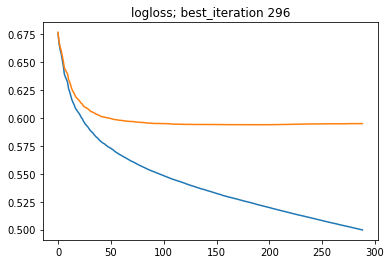

In [21]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

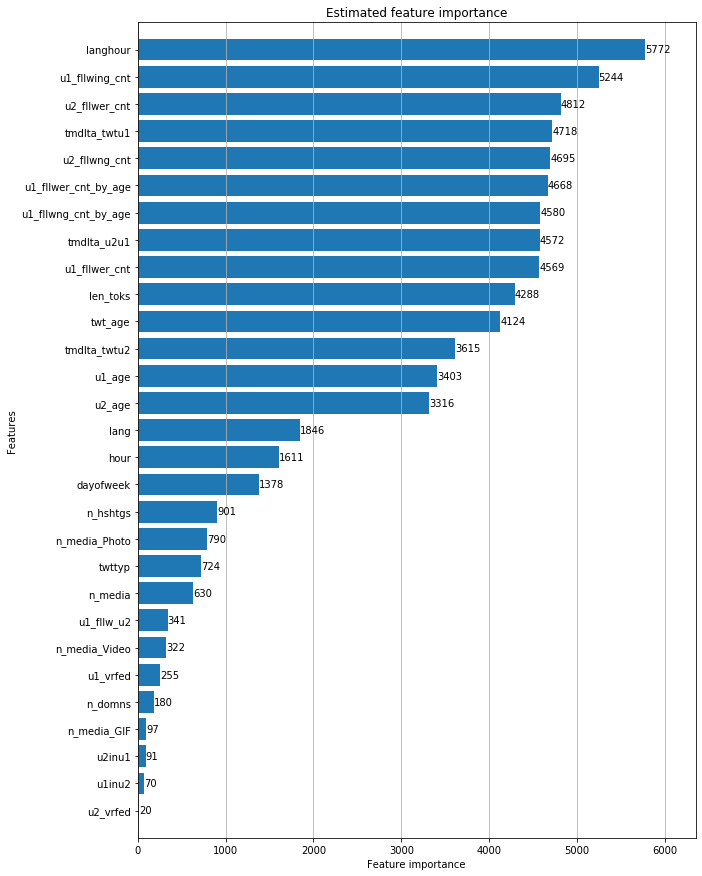

In [22]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [23]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
28,langhour,5772
3,u1_fllwing_cnt,5244
5,u2_fllwer_cnt,4812
21,tmdlta_twtu1,4718
6,u2_fllwng_cnt,4695
26,u1_fllwer_cnt_by_age,4668
27,u1_fllwng_cnt_by_age,4580
20,tmdlta_u2u1,4572
2,u1_fllwer_cnt,4569
11,len_toks,4288


In [24]:
col2imp = dict(zip(bst.feature_name(), bst.feature_importance()))
sorted(col2imp.items(), key=lambda x: -x[1])

[('langhour', 5772),
 ('u1_fllwing_cnt', 5244),
 ('u2_fllwer_cnt', 4812),
 ('tmdlta_twtu1', 4718),
 ('u2_fllwng_cnt', 4695),
 ('u1_fllwer_cnt_by_age', 4668),
 ('u1_fllwng_cnt_by_age', 4580),
 ('tmdlta_u2u1', 4572),
 ('u1_fllwer_cnt', 4569),
 ('len_toks', 4288),
 ('twt_age', 4124),
 ('tmdlta_twtu2', 3615),
 ('u1_age', 3403),
 ('u2_age', 3316),
 ('lang', 1846),
 ('hour', 1611),
 ('dayofweek', 1378),
 ('n_hshtgs', 901),
 ('n_media_Photo', 790),
 ('twttyp', 724),
 ('n_media', 630),
 ('u1_fllw_u2', 341),
 ('n_media_Video', 322),
 ('u1_vrfed', 255),
 ('n_domns', 180),
 ('n_media_GIF', 97),
 ('u2inu1', 91),
 ('u1inu2', 70),
 ('u2_vrfed', 20)]

In [25]:
[o[0] for o in sorted(col2imp.items(), key=lambda x: -x[1]) if o[1]>0]

['langhour',
 'u1_fllwing_cnt',
 'u2_fllwer_cnt',
 'tmdlta_twtu1',
 'u2_fllwng_cnt',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'tmdlta_u2u1',
 'u1_fllwer_cnt',
 'len_toks',
 'twt_age',
 'tmdlta_twtu2',
 'u1_age',
 'u2_age',
 'lang',
 'hour',
 'dayofweek',
 'n_hshtgs',
 'n_media_Photo',
 'twttyp',
 'n_media',
 'u1_fllw_u2',
 'n_media_Video',
 'u1_vrfed',
 'n_domns',
 'n_media_GIF',
 'u2inu1',
 'u1inu2',
 'u2_vrfed']

# eval

In [26]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 1min 46s, sys: 0 ns, total: 1min 46s
Wall time: 17.3 s


In [27]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

CPU times: user 5.96 s, sys: 0 ns, total: 5.96 s
Wall time: 6.3 s


In [28]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.8202
auc_vl:  0.6866
auc_val: 0.6807

rce_tr:  27.4224
rce_vl:  13.5627
rce_val: 13.2248


## score

In [29]:
print(f'-{auc_val:.4f}-{rce_val:.4f}')

-0.6807-13.2248


# save results

In [30]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [31]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
col2tgtenc = results['col2tgtenc']
cols_feat = results['cols_feat']
tgt_encoder = results['tgt_encoder']

## prep

In [32]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
    nrows=10
)

CPU times: user 3.71 ms, sys: 5.98 ms, total: 9.69 ms
Wall time: 8.93 ms


In [33]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

2020-04-11 22:26:24 start
2020-04-11 22:26:24 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-11 22:26:24 freq of tags
2020-04-11 22:26:24 done
CPU times: user 202 ms, sys: 0 ns, total: 202 ms
Wall time: 216 ms


In [34]:
encoded_tst = tgt_encoder.transform(dftst[col2tgtenc].astype(object))
tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tst.columns]
encoded_tst.columns = tgtenc_columns
dftst = pd.concat([dftst, encoded_tst], 1)
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

## predict

In [35]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 26.2 ms, sys: 68.5 ms, total: 94.7 ms
Wall time: 61.5 ms


In [36]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)